In [312]:
#imports and global variables
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import random

WORLDX, WORLDY = 60, 60

In [313]:
#definition of a robot state
class RobotState:
    def __init__(self, x, y, Angle, width, height):
        self.x = x
        self.y = y
        self.angle = Angle
        self.width = width
        self.height = height

    def __hash__(self):
        # Hash based on the attributes you want to consider
        return hash((self.x, self.y, self.angle, self.width, self.height))

    def __eq__(self, other):
        # Check for equality based on the attributes you want to consider
        if isinstance(other, RobotState):
            return (self.x, self.y, self.angle, self.width, self.height) == (other.x, other.y, other.angle, other.width, other.height)
        return False

In [314]:
def doLineSegmentsIntersect(x1, y1, x2, y2, x3, y3, x4, y4):
    # Check if the line segment (x1, y1)-(x2, y2) intersects with (x3, y3)-(x4, y4)
    def ccw(A, B, C):
        return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

    return (ccw([x1, y1], [x3, y3], [x4, y4]) != ccw([x2, y2], [x3, y3], [x4, y4]) and
            ccw([x1, y1], [x2, y2], [x3, y3]) != ccw([x1, y1], [x2, y2], [x4, y4]))

In [315]:
def edgeIntersectsRectangle(x1, y1, x2, y2, rect):
    # Check if the line defined by (x1, y1) and (x2, y2) intersects with the rectangle
    x, y, w, h = rect.get_x(), rect.get_y(), rect.get_width(), rect.get_height()

    # Define the four edges of the rectangle
    edges = [
        [(x, y), (x + w, y)],
        [(x + w, y), (x + w, y + h)],
        [(x + w, y + h), (x, y + h)],
        [(x, y + h), (x, y)]
    ]

    for edge in edges:
        x3, y3 = edge[0]
        x4, y4 = edge[1]

        # Check for intersection between the two line segments
        if doLineSegmentsIntersect(x1, y1, x2, y2, x3, y3, x4, y4):
            return True

    return False

In [316]:
def rectanglesOverlap(robot: RobotState, rect2: Rectangle):
    angle = np.deg2rad(robot.angle)

    # Calculate the coordinates of the robot's corners
    up_r = (robot.x + robot.width * np.cos(angle), robot.y + robot.width * np.sin(angle))
    up_l = (robot.x - robot.height * np.sin(angle), robot.y + robot.height * np.cos(angle))
    low_r = (robot.x + robot.width * np.cos(angle), robot.y + robot.width * np.sin(angle))
    low_l = (robot.x - robot.height * np.sin(angle), robot.y + robot.height * np.cos(angle))

    coords = [low_l, low_r, up_r, up_l]

    # Check if any corner of the robot is inside the obstacle boundaries
    for point in coords:
        if (rect2.get_x() - (robot.height*0.2) <= point[0] <= rect2.get_x() + rect2.get_width() + (robot.height*0.2) and
            rect2.get_y() - (robot.height*0.2) <= point[1] <= rect2.get_y() + rect2.get_height() + (robot.height*0.2)):
                return True

    # Check for edge-rectangle intersection
    for i in range(4):
        next_i = (i + 1) % 4
        x1, y1 = coords[i]
        x2, y2 = coords[next_i]

        # Check if the edge between two consecutive corners intersects the obstacle
        if edgeIntersectsRectangle(x1, y1, x2, y2, rect2):
            return True

    return False

In [317]:
def outOfWorld(robot):
    angle = np.deg2rad(robot.angle)

    #upper right coordinates
    x1 = robot.x + robot.width * np.cos(robot.angle) - robot.height * np.sin(angle)
    y1 = robot.y + robot.width * np.sin(robot.angle) + robot.height * np.cos(angle)

    #bellow world borders
    if x1 < 0 or y1 < 0:
        return True

    #above world borders
    if x1 > WORLDX or y1 > WORLDY:
        return True

    return False

In [318]:
def isValidConfiguration(robot, obstacles):
    if outOfWorld(robot):
        return False
    
    for obstacle in obstacles:
        if rectanglesOverlap(robot, obstacle):
            return False
        
    return True

In [319]:
def hasCollision(node1, node2, obstacles):
    # Define the number of points to sample along the edge for collision checking
    num_points = 100

    # Calculate the step size for sampling points along the edge
    dx = (node2.x - node1.x) / num_points
    dy = (node2.y - node1.y) / num_points

    # Check each point along the edge for collision
    for i in range(num_points + 1):
        x = node1.x + i * dx
        y = node1.y + i * dy
        robot_at_point = RobotState(x, y, node1.angle, node1.width, node1.height)
        
        if not isValidConfiguration(robot_at_point, obstacles):
            return True  # Collision detected

    return False  # No collision detected

In [320]:
def RRT(start, goal, obs, maxIter=500000, stepSize=1, goalBias=0.4, goalRange=0.5):
    # Create the tree as a dictionary of nodes with parent-child relationships
    tree = {start: None}

    # Expansion of the tree
    for _ in range(maxIter):
        # Setting a random state
        if random.random() < goalBias:
            randomConfig = goal
        else:
            randomConfig = RobotState(random.uniform(0, WORLDX - 1), random.uniform(0, WORLDY - 1), random.uniform(0, 180), start.width, start.height)

        # Find nearest node in the tree to the random state
        nearest = min(tree.keys(), key=lambda node: np.sqrt((node.x - randomConfig.x)**2 + (node.y - randomConfig.y)**2))

        # Resizing so we don't take steps longer than stepSize
        dx = randomConfig.x - nearest.x
        dy = randomConfig.y - nearest.y
        dist = np.sqrt(dx**2 + dy**2)

        if dist > stepSize:
            dx = (dx / dist) * stepSize
            dy = (dy / dist) * stepSize
        
        # Calculating new position
        new_x = nearest.x + dx
        new_y = nearest.y + dy
        new_angle = randomConfig.angle

        new_node = RobotState(new_x, new_y, new_angle, start.width, start.height)
        
        # Check if the new node position is valid
        if isValidConfiguration(new_node, obs) and not hasCollision(nearest, new_node, obs):
            tree[new_node] = nearest  # Add the new node with its parent
            # Check if we are close enough to the goal position (within a certain range)
            if np.sqrt((new_x - goal.x)**2 + (new_y - goal.y)**2) <= goalRange:
                # Reconstruct the path from the goal to the start
                path = [goal]
                current_node = goal
                while current_node != start:
                    parent_node = tree.get(current_node)  # Use .get() to handle KeyError
                    if parent_node is not None:
                        path.append(parent_node)
                        current_node = parent_node
                    else:
                        # Handle the case where the path cannot be reconstructed
                        return tree
                path.reverse()  # Reverse the path to start from the root
                return path

    # If no path is found, return hole tree
    return tree

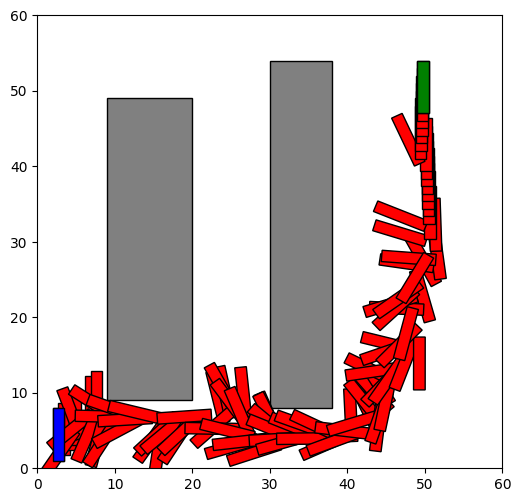

In [321]:
# Define obstacles
obs1 = Rectangle((9, 9), 11, 40, angle=0, edgecolor='k', facecolor='gray')
obs2 = Rectangle((30, 8), 8, 46, angle=0, edgecolor='k', facecolor='gray')
# obs3 = Rectangle((43, 20), 18, 8, angle=0, edgecolor='k', facecolor='gray')
obstacles = [obs1, obs2]

# Define the robot's shape
robot_width = 1.5
robot_height = 7

# Define the robot's initial and goal states
start = RobotState(2, 1, 0, robot_width, robot_height)
goal = RobotState(49, 47, 0, robot_width, robot_height)

# Perform RRT path planning
tree = RRT(start, goal, obstacles)
if tree:
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
    # Visualize the path
    ax.set_xlim(0, WORLDX)
    ax.set_ylim(0, WORLDY)

    for obs in obstacles:
        ax.add_patch(obs)

    for state in tree:
        robot_shape = Rectangle((state.x, state.y), state.width, state.height, rotation_point='xy', angle=state.angle, edgecolor='k', facecolor='red')
        ax.add_patch(robot_shape)
else:
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
    # Visualize the path
    ax.set_xlim(0, WORLDX)
    ax.set_ylim(0, WORLDY)

    for obs in obstacles:
        ax.add_patch(obs) 
    print("did not find path, execute again")
    
ax.add_patch(Rectangle((goal.x, goal.y), goal.width, goal.height, angle=goal.angle, edgecolor='k', facecolor='green'))
ax.add_patch(Rectangle((start.x, start.y), start.width, start.height, angle=start.angle, edgecolor='k', facecolor='blue'))

plt.show()